<a href="https://colab.research.google.com/github/rdwn354/Tensorflow_doc/blob/main/CNN/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-11-28 15:10:21--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.97.207, 142.251.107.207, 74.125.196.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.97.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  59.7MB/s    in 1.4s    

2023-11-28 15:10:23 (59.7 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [5]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(input_shape = (150,150,3),
                                include_top = False,
                                weights = None)

pre_trained_model.load_weights(local_weights_file)
for layer in pre_trained_model.layers:
  layer.trainable = False

In [7]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 74, 74, 32)           864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 74, 74, 32)           96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 74, 74, 32)           0         ['batch_normalizati

In [8]:
# Choose `mixed7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [10]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.Dropout(.2)(x)
x = layers.Dense(1, activation = 'sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 74, 74, 32)           864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 74, 74, 32)           96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 74, 74, 32)           0         ['batch_normalization_94[0

In [11]:
model.compile(optimizer = 'RMSprop',
              loss = 'binary_crossentropy',
              metrics = ['accuracy']
              )

In [12]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip

--2023-11-28 15:24:47--  https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.212.207, 173.194.213.207, 173.194.215.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.212.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   163MB/s    in 0.4s    

2023-11-28 15:24:48 (163 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [16]:
import zipfile
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

zip_ref = zipfile.ZipFile('./cats_and_dogs_filtered.zip')
zip_ref.extractall("temp/")
zip_ref.close()

base_dir = 'temp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(base_dir, 'cats')
train_dogs_dir = os.path.join(base_dir, 'dogs')
validation_cats_dir = os.path.join(base_dir, 'cats')
validation_dogs_dir = os.path.join(base_dir, 'dogs')

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40,
                                   width_shift_range = .2,
                                   height_shift_range = .2,
                                   shear_range = .2,
                                   zoom_range = .2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary',
                                                    target_size = (150,150))

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        batch_size = 20,
                                                        class_mode = 'binary',
                                                        target_size = (150,150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [17]:
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    steps_per_epoch = 100,
                    epochs = 20,
                    validation_steps = 50,
                    verbose = 2)

Epoch 1/20
100/100 - 234s - loss: 1.1652 - accuracy: 0.8465 - val_loss: 0.3181 - val_accuracy: 0.8930 - 234s/epoch - 2s/step
Epoch 2/20
100/100 - 194s - loss: 0.3028 - accuracy: 0.8825 - val_loss: 0.2107 - val_accuracy: 0.9290 - 194s/epoch - 2s/step
Epoch 3/20
100/100 - 230s - loss: 0.2230 - accuracy: 0.9065 - val_loss: 0.1250 - val_accuracy: 0.9500 - 230s/epoch - 2s/step
Epoch 4/20
100/100 - 229s - loss: 0.2017 - accuracy: 0.9195 - val_loss: 0.0829 - val_accuracy: 0.9640 - 229s/epoch - 2s/step
Epoch 5/20
100/100 - 229s - loss: 0.1844 - accuracy: 0.9250 - val_loss: 0.1329 - val_accuracy: 0.9500 - 229s/epoch - 2s/step
Epoch 6/20
100/100 - 228s - loss: 0.2062 - accuracy: 0.9245 - val_loss: 0.1023 - val_accuracy: 0.9660 - 228s/epoch - 2s/step
Epoch 7/20
100/100 - 228s - loss: 0.1739 - accuracy: 0.9335 - val_loss: 0.0970 - val_accuracy: 0.9650 - 228s/epoch - 2s/step
Epoch 8/20
100/100 - 228s - loss: 0.1759 - accuracy: 0.9320 - val_loss: 0.1073 - val_accuracy: 0.9620 - 228s/epoch - 2s/step


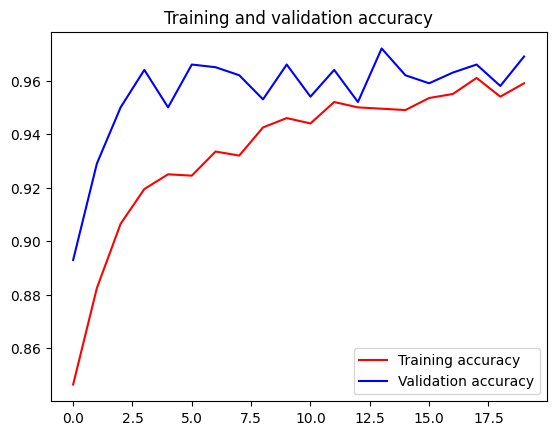

<Figure size 640x480 with 0 Axes>

In [18]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()